# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [3]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1851,z-1598953V,VW Tiguan,economy,petrol,4.14,2015,80326,2020,29.41,electro_bug
2152,J87382695C,VW Polo,economy,petrol,3.56,2012,22401,2015,50.50,engine_overheat
1129,y35238235q,Smart ForFour,economy,petrol,4.44,2015,75319,2020,33.92,wheel_shake
2086,V-1493273B,Renault Sandero,standart,petrol,6.02,2015,74211,2019,37.61,engine_fuel
989,p-1229769J,Renault Sandero,standart,petrol,5.56,2015,75476,2014,35.29,engine_overheat


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [7]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
687704,A21159512J,w-4839718z,t1C,2020-01-30,2.39,57,621,41,116.835425,0,2.395494e+03,0,-7.936918,0.000
532405,H15791865k,l14731037p,k1R,2020-03-14,4.58,90,1072,53,96.163975,8,3.592499e+03,0,-10.629853,-4.300
488605,K11880728f,i10344980A,k1C,2020-01-08,4.86,42,499,45,70.000000,2,1.587338e+03,0,0.323060,-0.520
242516,l19034997p,Q75686415a,w1m,2020-03-12,8.82,32,251,53,76.000000,0,1.677306e+03,0,-1.811727,-8.000
295562,p56102786J,U43132093r,T1j,2020-02-28,3.70,34964,419562,84,160.300007,0,2.964733e+06,0,-11.391600,-35.956


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [10]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
668,34,9.9,19,20.0,W57474244I,1,2019-11-20
2871,35,8.3,476,14.0,Y17674909F,1,2020-6-16
10455,28,8.6,929,13.0,p22743709F,1,2018-12-17
12148,26,8.1,1086,52.0,c81133039M,0,2019-2-4
9813,23,8.4,1013,3.0,c94237435W,1,2020-11-7


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [11]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
69341,M-1335244r,NL,2020-10-23 9:50,repair,5.6,19
77037,H10820003r,JM,2018-12-22 15:9,reparking,1.0,34
93808,P10499796W,CR,2020-6-21 21:15,repair,6.7,31
126762,t-1660621F,OZ,2019-3-1 20:12,reparking,1.0,26
93084,F68295874Z,AX,2020-7-10 12:1,refuel_check,1.0,32


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).



---



---



# **РЕШЕНИЕ**

In [349]:
unique_values_count = car_train['car_id'].nunique() #определение количества уникальных id машин
print(unique_values_count)# вывод количество данных уникальных
print(car_train.info())#информация общая о датасете для определения количества различных машин в датасете

2337
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_reg     2337 non-null   float64
 9   target_class   2337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 182.7+ KB
None


In [351]:
unique_values_count_2 = rides_info['user_id'].nunique() #определение количества уникальных id водителей
print(unique_values_count_2)# вывод количество данных уникальных

15153


In [353]:
# Для каждой машины подсчитываем необходимые признаки из базы rides_info - данные о поездках

result_car_id = rides_info.groupby('car_id').agg({
    'rating': ['min', 'mean'], #минимальный рейтинг за все поездки, средний рейтинг за все поездки - по заданию
    'distance': 'sum', #общее количество километров, которое машина проехала - по заданию
    'speed_max': 'max', #максимальная скорость - по заданию
    'ride_id': 'count', #общее количество поездок для каждой машины - по заданию

    'stop_times':'sum', #общее количество остановок  - количество остановок увеличивает износ машины
    'ride_duration':'sum',# общая длительность поездок
    'deviation_normal':['min'], #максимальное отклонение от нормы вниз  - покажет интенсивность износа
    'user_ride_quality': 'mean' #средняя оценка вождения машины (как стиль вождения)
})

#print(result_car_id)

# Переименовываем столбцы для удобства
result_car_id.columns = ['min_rating', 'mean_rating', 'sum_distance', 'max_speed', 
                         'count_rides', 'total_stops', 'sum_ride_duration', 'min_deviation_normal', 'mean_user_ride_quality']

# Создаем новый DataFrame с агрегированными данными
new_df = pd.DataFrame(result_car_id)

# Выводим новый DataFrame
#print(new_df)

In [355]:
new_df.reset_index(inplace=True)

# Присоединяем new_df к rides_info через столбец 'car_id' с помощью метода merge
merged_df = car_train.merge(new_df, on='car_id', how='left')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car_id                  2337 non-null   object 
 1   model                   2337 non-null   object 
 2   car_type                2337 non-null   object 
 3   fuel_type               2337 non-null   object 
 4   car_rating              2337 non-null   float64
 5   year_to_start           2337 non-null   int64  
 6   riders                  2337 non-null   int64  
 7   year_to_work            2337 non-null   int64  
 8   target_reg              2337 non-null   float64
 9   target_class            2337 non-null   object 
 10  min_rating              2337 non-null   float64
 11  mean_rating             2337 non-null   float64
 12  sum_distance            2337 non-null   float64
 13  max_speed               2337 non-null   float64
 14  count_rides             2337 non-null   

In [357]:
merged_df.sample(5)#вывод 5-ти случайных строк

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,sum_distance,max_speed,count_rides,total_stops,sum_ride_duration,min_deviation_normal,mean_user_ride_quality
711,j20079629P,Smart Coupe,economy,petrol,3.12,2016,101075,2017,27.13,gear_stick,0.1,4.267644,9.698816e+06,117.764455,174,149,222353,-11.901,6.887961
424,f-2278263a,Renault Kaptur,standart,petrol,4.82,2013,43819,2020,26.24,break_bug,0.1,5.214540,1.476612e+07,126.711409,174,160,328940,-25.235,-2.876026
972,E86045670c,Kia Rio X,economy,petrol,3.54,2012,25095,2018,38.89,break_bug,0.1,5.396552,8.993089e+06,125.968069,174,150,216703,-8.599,1.288162
1439,U-6122657S,Skoda Rapid,economy,petrol,6.00,2014,68017,2014,31.45,electro_bug,0.0,4.048966,2.454837e+07,181.016855,174,143,500738,-26.763,0.446813
689,q-1744366u,Kia Rio,economy,petrol,5.62,2011,2814,2016,45.57,engine_ignition,0.1,3.932241,1.442024e+07,180.337429,174,136,318204,-2.529,-7.181558


_______
_______

Так как данные в таблице driver_info содержат данные по id водителей и не содержит данных по id машин, а основная база не содержит данных по водителям, то необходимо сначала привести в соотвествие данные по водителям, а затем их сгруппировать по id  машин и соединить с основной базой.

In [361]:
merged_df_2 = rides_info.merge(driver_info, on='user_id', how='left')
merged_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739500 entries, 0 to 739499
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             739500 non-null  object 
 1   car_id              739500 non-null  object 
 2   ride_id             739500 non-null  object 
 3   ride_date           739500 non-null  object 
 4   rating              739500 non-null  float64
 5   ride_duration       739500 non-null  int64  
 6   ride_cost           739500 non-null  int64  
 7   speed_avg           739500 non-null  int64  
 8   speed_max           736139 non-null  float64
 9   stop_times          739500 non-null  int64  
 10  distance            739500 non-null  float64
 11  refueling           739500 non-null  int64  
 12  user_ride_quality   736872 non-null  float64
 13  deviation_normal    739500 non-null  float64
 14  age                 739500 non-null  int64  
 15  user_rating         739500 non-nul

In [365]:
# user_id / age / sex — идентификатор, возраст и пол водителя, соответственно
   # user_rating — общий рейтинг пользователя за все поездки к концу 2021 года
   # user_rides — общее количество поездок к концу 2021 года
   # user_time_accident — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)
   # first_ride_date — дата первой поездки

#не важные данные  - 
#пол (больше влияет не пол, а рейтинг),
#дата первой поездки(не определяет стиля вождения),
#общее количество поездок (может быть на разных машинах), 
#число инцидентов - определяет водителя, а не количество поломок, т.к. возможны поездки на других машинах


result_2 = merged_df_2.groupby('car_id').agg({
    'user_id': 'nunique', #количество водителей - может быть признаком знакомства с особенностью машины
    'user_rating':'mean',# средний рейтинг водителей - может быть полезен с точки зрения вероятности поломки 
    'age':['min', 'mean', 'max'] #минимальный, средний и максимальный возраст водителей - может быть важен    
})

# Переименовываем столбцы для удобства
result_2.columns = ['sum_user_id', 'mean_user_rating', 'min_age','mean_age', 'max_age']

# Создаем новый DataFrame с агрегированными данными
new_df_2 = pd.DataFrame(result_2)

# Выводим новый DataFrame
print(new_df_2)




            sum_user_id  mean_user_rating  min_age   mean_age  max_age
car_id                                                                
A-1049127W          172          7.817816       18  33.666667       60
A-1079539w          173          7.773563       18  32.344828       61
A-1162143G          172          8.149425       18  34.241379       58
A-1228282M          174          8.045402       18  33.609195       60
A-1339912r          172          8.195402       18  33.948276       58
...                 ...               ...      ...        ...      ...
z73688663a          168          8.156322       18  32.327586       58
z73740510r          171          8.096552       21  36.097701       57
z86911952C          172          8.014368       18  33.195402       55
z91353693Z          173          8.024138       18  34.839080       61
z91796444U          174          7.763218       18  33.143678       56

[4250 rows x 5 columns]


In [367]:
new_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4250 entries, A-1049127W to z91796444U
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sum_user_id       4250 non-null   int64  
 1   mean_user_rating  4250 non-null   float64
 2   min_age           4250 non-null   int64  
 3   mean_age          4250 non-null   float64
 4   max_age           4250 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 199.2+ KB


In [369]:
merged_df_3 = merged_df.merge(new_df_2_reset, on='car_id', how='left')
merged_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car_id                  2337 non-null   object 
 1   model                   2337 non-null   object 
 2   car_type                2337 non-null   object 
 3   fuel_type               2337 non-null   object 
 4   car_rating              2337 non-null   float64
 5   year_to_start           2337 non-null   int64  
 6   riders                  2337 non-null   int64  
 7   year_to_work            2337 non-null   int64  
 8   target_reg              2337 non-null   float64
 9   target_class            2337 non-null   object 
 10  min_rating              2337 non-null   float64
 11  mean_rating             2337 non-null   float64
 12  sum_distance            2337 non-null   float64
 13  max_speed               2337 non-null   float64
 14  count_rides             2337 non-null   

In [371]:
merged_df_3.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,count_rides,total_stops,sum_ride_duration,min_deviation_normal,mean_user_ride_quality,sum_user_id,mean_user_rating,min_age,mean_age,max_age
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,174,630,284624,-9.000,-0.901190,170,8.229885,18,33.511494,62
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,174,145,386833,-25.088,14.018105,174,7.988506,18,34.988506,57
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,174,140,356501,-12.400,0.722771,173,7.843103,18,32.839080,58
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,174,150,338171,-12.691,-4.290370,170,8.524138,21,34.977011,57
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,174,132,278016,-20.907,-13.465342,171,8.112069,18,34.298851,57


___

In [374]:
fix_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   car_id          146000 non-null  object 
 1   worker_id       146000 non-null  object 
 2   fix_date        146000 non-null  object 
 3   work_type       146000 non-null  object 
 4   destroy_degree  146000 non-null  float64
 5   work_duration   146000 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [376]:
fix_info.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47


In [378]:

   # worker_id / car_id — идентификатор работника и машины
   #work_type / work_duration — тип и длительность (в часах) проводимой работы
   # destroy_degree — степень износа/поврежденности машины в случае поломки
   #fix_date — время начала ремонта (снятия машины с линии)
#не значащие данные
#worker_id - вряд ли имееет значение
#fix_date - вероятнее всего не может быть в прямую оценена


result_3 = fix_info.groupby('car_id').agg({
    'work_duration': ['min', 'mean', 'max'], #длительность простоя в часах: миниммальная, максимальная, средняя
})

# Переименовываем столбцы для удобства
result_3.columns = ['min_work_duration', 'mean_work_duration', 'max_work_duration']

# Создаем новый DataFrame с агрегированными данными
new_df_3 = pd.DataFrame(result_3)

# Выводим новый DataFrame
print(new_df_3)



            min_work_duration  mean_work_duration  max_work_duration
car_id                                                              
A-1049127W                  1           27.485714                 56
A-1079539w                  3           27.382353                 64
A-1162143G                  1           27.823529                 69
A-1228282M                  3           24.647059                 65
A-1339912r                  3           28.617647                 71
...                       ...                 ...                ...
z73688663a                 11           26.028571                 59
z73740510r                  3           25.457143                 49
z86911952C                  1           26.942857                 48
z91353693Z                  1           28.764706                 68
z91796444U                  1           25.942857                 63

[4250 rows x 3 columns]


In [380]:
merged_df_4 = merged_df_3.merge(new_df_3, on='car_id', how='left')
merged_df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car_id                  2337 non-null   object 
 1   model                   2337 non-null   object 
 2   car_type                2337 non-null   object 
 3   fuel_type               2337 non-null   object 
 4   car_rating              2337 non-null   float64
 5   year_to_start           2337 non-null   int64  
 6   riders                  2337 non-null   int64  
 7   year_to_work            2337 non-null   int64  
 8   target_reg              2337 non-null   float64
 9   target_class            2337 non-null   object 
 10  min_rating              2337 non-null   float64
 11  mean_rating             2337 non-null   float64
 12  sum_distance            2337 non-null   float64
 13  max_speed               2337 non-null   float64
 14  count_rides             2337 non-null   

In [382]:
merged_df_4.head(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,min_deviation_normal,mean_user_ride_quality,sum_user_id,mean_user_rating,min_age,mean_age,max_age,min_work_duration,mean_work_duration,max_work_duration
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,-9.000,-0.901190,170,8.229885,18,33.511494,62,7,26.657143,56
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,-25.088,14.018105,174,7.988506,18,34.988506,57,4,24.942857,48
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,-12.400,0.722771,173,7.843103,18,32.839080,58,1,26.142857,59
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,-12.691,-4.290370,170,8.524138,21,34.977011,57,1,28.771429,64
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,-20.907,-13.465342,171,8.112069,18,34.298851,57,10,28.028571,65


### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [284]:
# YOUR CODE HERE

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [385]:
#отсеивание признаков
merged_df_4.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car_id                  2337 non-null   object 
 1   model                   2337 non-null   object 
 2   car_type                2337 non-null   object 
 3   fuel_type               2337 non-null   object 
 4   car_rating              2337 non-null   float64
 5   year_to_start           2337 non-null   int64  
 6   riders                  2337 non-null   int64  
 7   year_to_work            2337 non-null   int64  
 8   target_reg              2337 non-null   float64
 9   target_class            2337 non-null   object 
 10  min_rating              2337 non-null   float64
 11  mean_rating             2337 non-null   float64
 12  sum_distance            2337 non-null   float64
 13  max_speed               2337 non-null   float64
 14  count_rides             2337 non-null   

In [387]:
#определим количество уникальных значений в каждом из столбцов

# Получение количества уникальных значений в каждом столбце
unique_value_counts = merged_df_4.nunique()

# Вывод количества уникальных значений для каждого столбца
print(unique_value_counts)

car_id                    2337
model                       26
car_type                     4
fuel_type                    2
car_rating                 269
year_to_start                7
riders                    2306
year_to_work                 9
target_reg                1891
target_class                 9
min_rating                  91
mean_rating               2223
sum_distance              2337
max_speed                 1938
count_rides                  1
total_stops                269
sum_ride_duration         2328
min_deviation_normal      2090
mean_user_ride_quality    2337
sum_user_id                 30
mean_user_rating           785
min_age                      4
mean_age                   726
max_age                     13
min_work_duration           18
mean_work_duration         620
max_work_duration           44
dtype: int64


In [389]:
#в резудльтате полученных данных номер индивидуальный машины можно удалить
# Удаление столбца 'car_id'
merged_df_4 = merged_df_4.drop('car_id', axis=1)

# Вывод датафрейма после удаления столбца
print("\nПосле удаления столбца:")
merged_df_4.head(2)


После удаления столбца:


,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,...,min_deviation_normal,mean_user_ride_quality,sum_user_id,mean_user_rating,min_age,mean_age,max_age,min_work_duration,mean_work_duration,max_work_duration
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,...,-9.000,-0.901190,170,8.229885,18,33.511494,62,7,26.657143,56
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,...,-25.088,14.018105,174,7.988506,18,34.988506,57,4,24.942857,48


In [391]:
#в результате полученных данных count_rides можно удалить
# Удаление столбца 'B'
merged_df_4 = merged_df_4.drop('count_rides', axis=1)

# Вывод датафрейма после удаления столбца
print("\nПосле удаления столбца:")
merged_df_4.head(2)


После удаления столбца:


,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,...,min_deviation_normal,mean_user_ride_quality,sum_user_id,mean_user_rating,min_age,mean_age,max_age,min_work_duration,mean_work_duration,max_work_duration
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,...,-9.000,-0.901190,170,8.229885,18,33.511494,62,7,26.657143,56
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,...,-25.088,14.018105,174,7.988506,18,34.988506,57,4,24.942857,48


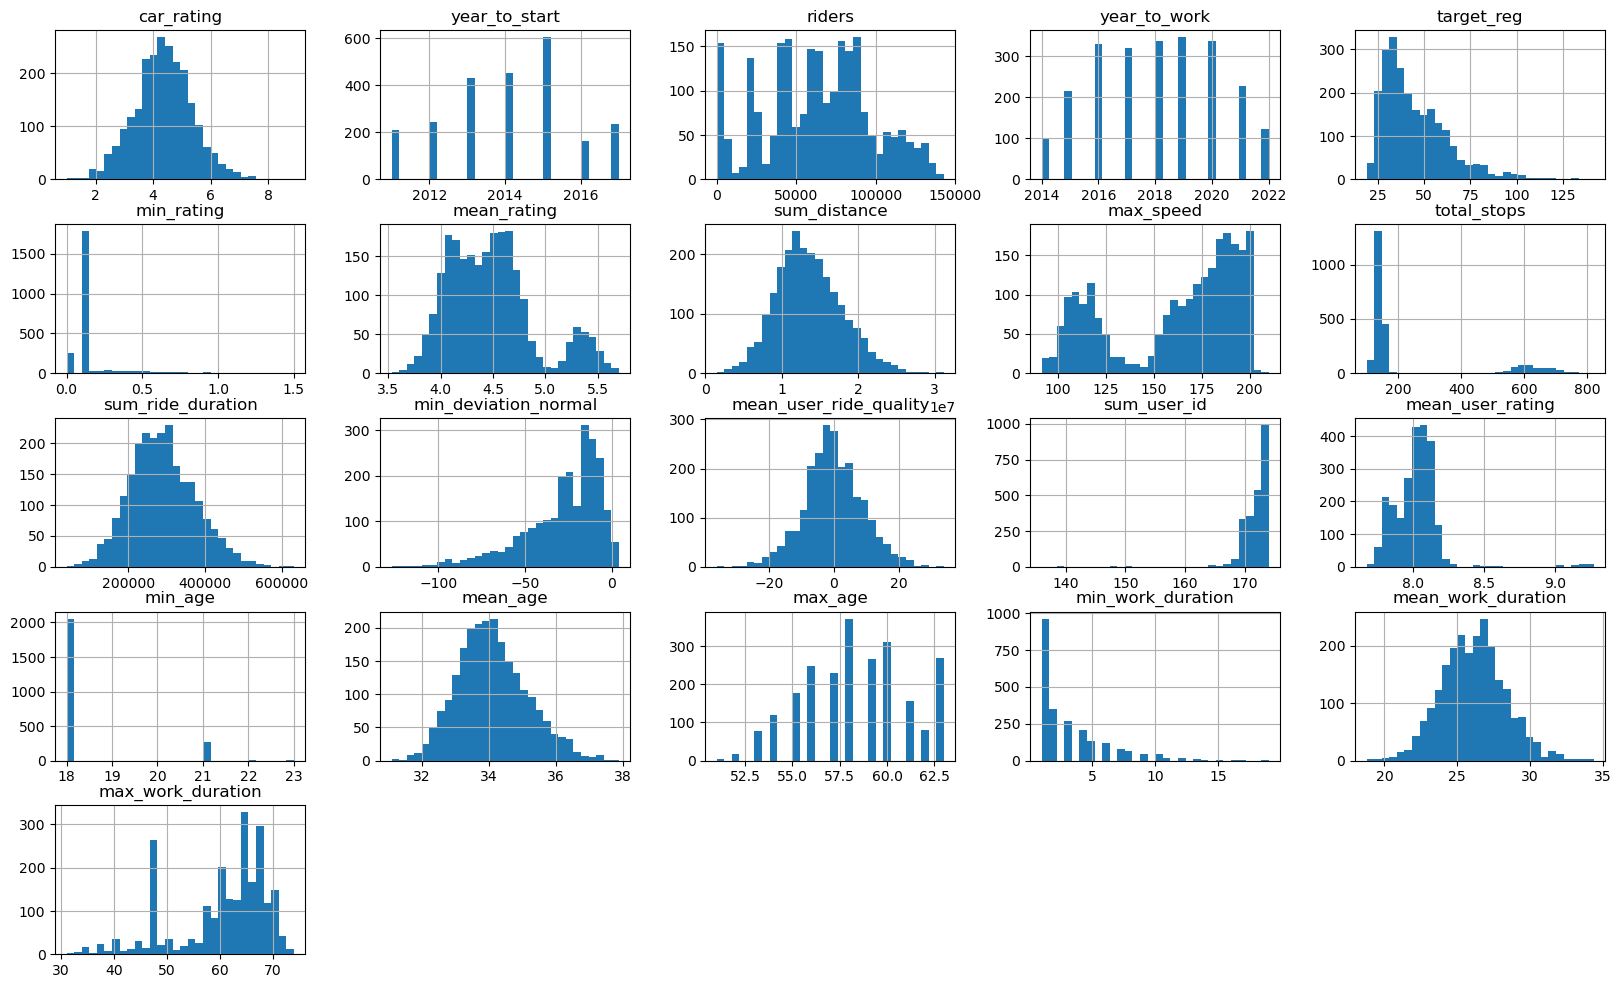

In [393]:
#Визуализация данных при помощи гистограмм
merged_df_4.hist(figsize = (20, 12), layout = (-1, 5), bins=30);

In [395]:
#для последующих работ необходимо категориальные признаки перевести в числовые
merged_df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   model                   2337 non-null   object 
 1   car_type                2337 non-null   object 
 2   fuel_type               2337 non-null   object 
 3   car_rating              2337 non-null   float64
 4   year_to_start           2337 non-null   int64  
 5   riders                  2337 non-null   int64  
 6   year_to_work            2337 non-null   int64  
 7   target_reg              2337 non-null   float64
 8   target_class            2337 non-null   object 
 9   min_rating              2337 non-null   float64
 10  mean_rating             2337 non-null   float64
 11  sum_distance            2337 non-null   float64
 12  max_speed               2337 non-null   float64
 13  total_stops             2337 non-null   int64  
 14  sum_ride_duration       2337 non-null   

In [397]:
from sklearn.preprocessing import LabelEncoder

#категориальные значения в датасете
#model
#car_type 
#fuel_type
#target_class  
# Определяем список категориальных столбцов
categorical_cols = merged_df_4.select_dtypes(include=['object']).columns

# Применяем Label Encoding к категориальным столбцам
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    merged_df_4[col] = label_encoders[col].fit_transform(merged_df_4[col])

# Выводим результат
merged_df_4.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,...,min_deviation_normal,mean_user_ride_quality,sum_user_id,mean_user_rating,min_age,mean_age,max_age,min_work_duration,mean_work_duration,max_work_duration
0,8,1,1,3.78,2015,76163,2021,108.53,0,0.1,...,-9.000,-0.901190,170,8.229885,18,33.511494,62,7,26.657143,56
1,23,1,1,3.90,2015,78218,2021,35.20,2,0.0,...,-25.088,14.018105,174,7.988506,18,34.988506,57,4,24.942857,48
2,16,3,1,6.30,2012,23340,2017,38.62,7,0.1,...,-12.400,0.722771,173,7.843103,18,32.839080,58,1,26.142857,59
3,12,0,1,4.04,2011,1263,2020,30.34,4,0.1,...,-12.691,-4.290370,170,8.524138,21,34.977011,57,1,28.771429,64
4,16,3,1,4.70,2012,26428,2017,30.45,4,0.1,...,-20.907,-13.465342,171,8.112069,18,34.298851,57,10,28.028571,65


<Axes: >

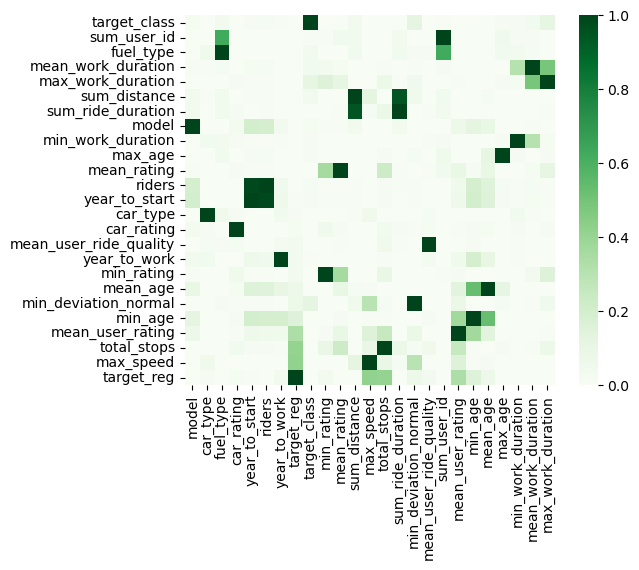

In [399]:
# визуализация при помощи линейной корреляции
corrs = merged_df_4.dropna().corr().round(3).sort_values('target_reg')
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

По результатам данной тепловой карты можно сделать вывод, что наибольшее линейное влияние оказывает на количество дней до поломки - 
максимальная скорость и количество остановов, и средний рейтинг водителя. Далее по степени выраженности корреляции влияет минимальный возраст водителя, показатели датчиков. 

______
## Phik

In [401]:
#Phik
!pip install phik -q

In [402]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'target_class', 'min_rating', 'mean_rating', 'sum_distance', 'max_speed', 'total_stops', 'sum_ride_duration', 'min_deviation_normal', 'mean_user_ride_quality', 'sum_user_id', 'mean_user_rating', 'min_age', 'mean_age', 'max_age', 'min_work_duration', 'mean_work_duration', 'max_work_duration']


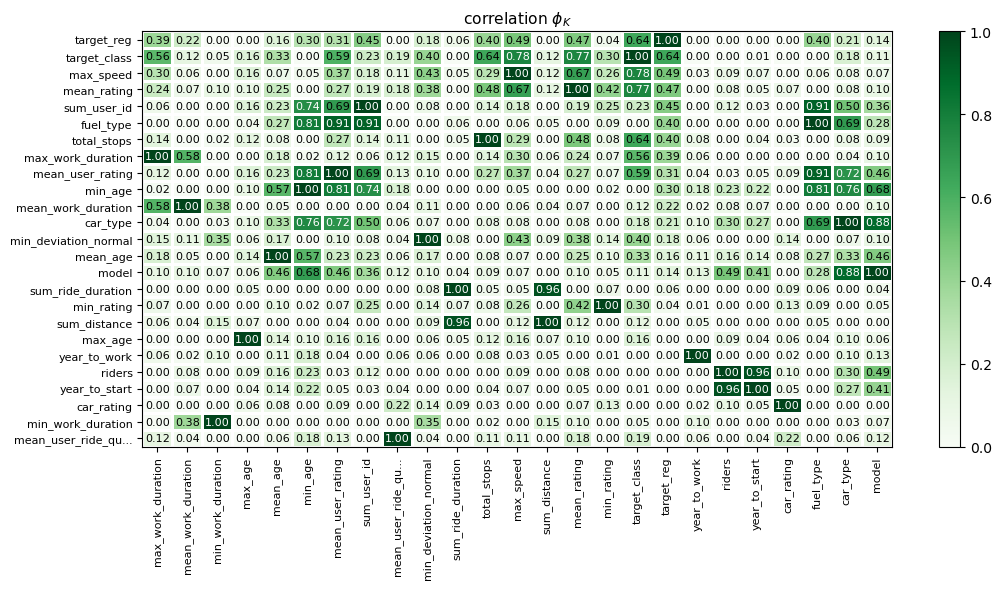

In [403]:
phik_overview = merged_df_4.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

**Выводы:** Данные Phik повторили данные, которые продемонстрировала линейная корреляция. Добавились значения лишь: тип поломки и количество водителей, заказывающих эти авто.

____
## Feature Importance

In [407]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

In [409]:
drop_cols = ['target_class', 'target_reg']

In [411]:
X = merged_df_4.drop(drop_cols, axis=1, errors = 'ignore')
y = merged_df_4['target_class'].fillna(0) #предыдущие данные то класс поломки и количество дней имеет корреляцию

In [413]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [415]:
model = CatBoostClassifier(random_state=42,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109043
0:	learn: 1.7063556	test: 1.7421041	best: 1.7421041 (0)	total: 15.1ms	remaining: 15.1s
100:	learn: 0.1021939	test: 0.2174119	best: 0.2174119 (100)	total: 1.24s	remaining: 11s
200:	learn: 0.0621171	test: 0.1984970	best: 0.1984970 (200)	total: 2.46s	remaining: 9.76s
300:	learn: 0.0416700	test: 0.1952702	best: 0.1952702 (300)	total: 3.68s	remaining: 8.55s
400:	learn: 0.0311384	test: 0.1939951	best: 0.1935969 (352)	total: 4.9s	remaining: 7.32s
500:	learn: 0.0239722	test: 0.1921519	best: 0.1920162 (471)	total: 6.12s	remaining: 6.1s
600:	learn: 0.0192233	test: 0.1929895	best: 0.1914427 (547)	total: 7.33s	remaining: 4.86s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1914426662
bestIteration = 547

Shrink model to first 548 iterations.


In [416]:
# таблица важности признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,max_speed,26.296889
1,mean_user_rating,17.211261
2,total_stops,16.930289
3,mean_rating,14.618362
4,min_rating,6.940174
5,max_work_duration,4.927181
6,mean_age,2.393371
7,sum_user_id,1.955141
8,min_deviation_normal,1.601140
9,car_rating,0.935455


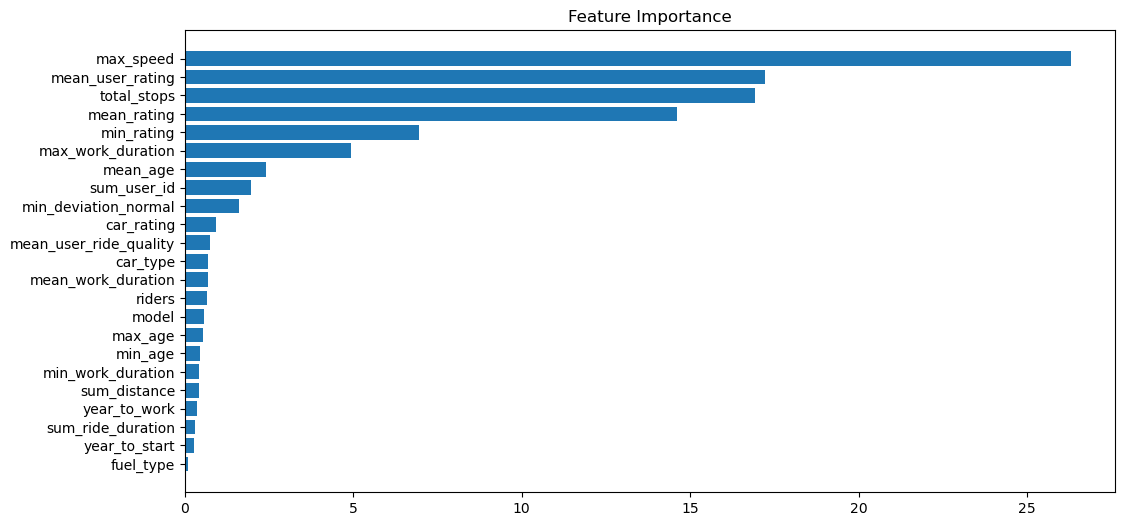

In [417]:
#визуализация полученных признаков
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

**Вывод:** по данным наибольшее влияние оказывает на целевую переменную - максимальная скорость, средний рейтинг водителя, количество остановок, средний рейтинг машины, средний рейтинг машины, минимальный рейтинг машины, максимальная длительность простоя и т.д. Наименьшее влияние оказывает: тип топлива, год начала работы. 

## Permutation Importance

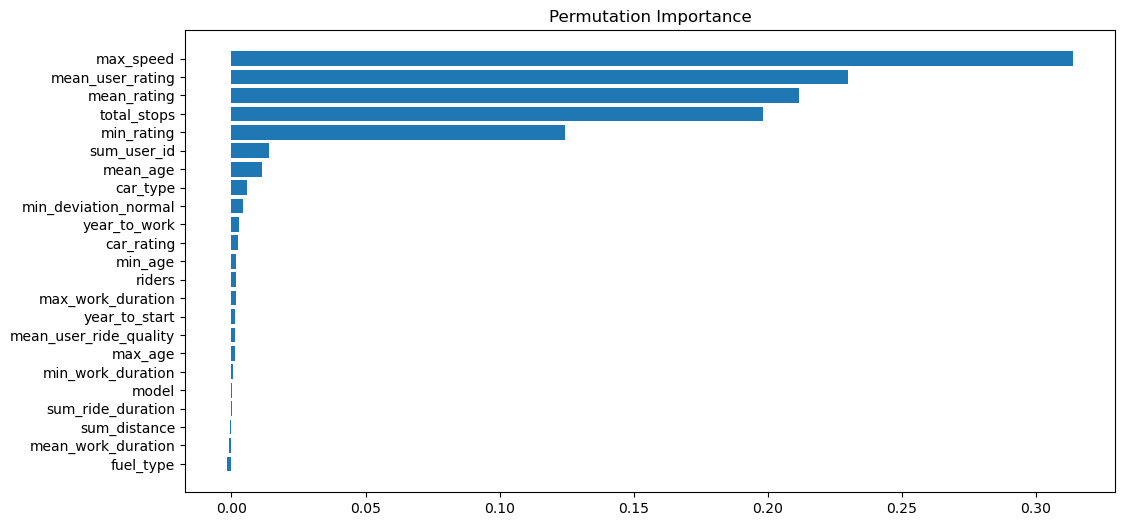

In [421]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

**Вывод:** наиболее важными признаками являются: максимальная скорость, средний рейтин водителя, средний рейтинг машины, количество остановок, минимальный рейтиг машины, количество водителей, средний возраст водителей. 
Минимальное влияние: модель, средняя длительность простоя, суммарная дистанция. 

По всем данным можно сделать вывод, что следует оставить:
- max_speed (максимальная скорость),
- mean_user_rating,
- total_stops,
- mean_rating,
- min_rating,
- max_work_duration,
- mean_age,
- sum_user_id,
- min_deviation_normal,
- car_rating,
- mean_user_ride_quality,
- car_type

Создаем датасет с выделенными параметрами.


In [426]:
# Выбираем определенные столбцы, которые должны остаться в новом датасете
selected_columns = ['max_speed', 'mean_user_rating', 'total_stops', 'mean_rating', 'min_rating', 'max_work_duration', 
                    'mean_age', 'sum_user_id', 'min_deviation_normal',
                   'car_rating', 'mean_user_ride_quality', 'car_type']

# Создаем новый датасет, содержащий только выбранные столбцы
new_df = merged_df_4[selected_columns]

# Сохраняем новый датасет в файл
new_df.to_csv('new_dataset.csv', index=False)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   max_speed               2337 non-null   float64
 1   mean_user_rating        2337 non-null   float64
 2   total_stops             2337 non-null   int64  
 3   mean_rating             2337 non-null   float64
 4   min_rating              2337 non-null   float64
 5   max_work_duration       2337 non-null   int64  
 6   mean_age                2337 non-null   float64
 7   sum_user_id             2337 non-null   int64  
 8   min_deviation_normal    2337 non-null   float64
 9   car_rating              2337 non-null   float64
 10  mean_user_ride_quality  2337 non-null   float64
 11  car_type                2337 non-null   int32  
dtypes: float64(8), int32(1), int64(3)
memory usage: 210.1 KB


____
____
____

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.